# Distance-based treatment effects

Based on the figures from Holodinsky et al. 2017 - "Drip and Ship Versus Direct to Comprehensive Stroke Center"

## Notebook admin

In [1]:
# Import packages
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Set up MatPlotLib
%matplotlib inline
# Change default colour scheme:
plt.style.use('seaborn-colorblind')

# Assumptions 

Fixed times for additional delays:

In [3]:
# All fixed times have units of minutes
fixed_times = dict(
    onset_to_ambulance_arrival = 60,
    ivt_arrival_to_treatment = 30,
    transfer_additional_delay = 60,
    travel_ivt_to_mt = 50,
    mt_arrival_to_treatment = 90,
    )

In [4]:
pd.DataFrame(fixed_times.values(), index=fixed_times.keys(), 
             columns=['Fixed time (minutes)'])

,Fixed time (minutes)
onset_to_ambulance_arrival,60
ivt_arrival_to_treatment,30
transfer_additional_delay,60
travel_ivt_to_mt,50
mt_arrival_to_treatment,90


Patient population:

In [5]:
patient_props = dict(
    lvo = 0.35,
    nlvo = 1.0-0.35, # 1-LVO
    lvo_mt_also_receiving_ivt = 0.85,
    lvo_treated_ivt_only = 0.0,
    lvo_treated_ivt_mt = 0.286,    # 0.286 gives 10% final MT if 35%LVO
    nlvo_treated_ivt_only = 0.155,    # 0.155 gives final 20% IVT
    )

treated_population = (
    patient_props['nlvo'] * patient_props['nlvo_treated_ivt_only'] +
    patient_props['lvo'] * patient_props['lvo_treated_ivt_mt'] +
    patient_props['lvo'] * patient_props['lvo_treated_ivt_only']
    )

patient_props['treated_population'] = treated_population

In [6]:
df_patients = pd.DataFrame(patient_props.values(), 
    index=patient_props.keys(), columns=['Proportion of patient population'])
df_patients['Comment'] = [
    'Proportion of LVO',
    'Proportion of nLVO', 
    'Proportion LVO MT also receiving IVT',
    'Proportion LVO admissions treated with IVT only',
    'Proportion LVO admissions treated with MT',
    'Proportion nLVO admissions treated with IVT',
    'Proportion all admissions treated'
    ]

df_patients

,Proportion of patient population,Comment
lvo,0.35000,Proportion of LVO
nlvo,0.65000,Proportion of nLVO
lvo_mt_also_receiving_ivt,0.85000,Proportion LVO MT also receiving IVT
lvo_treated_ivt_only,0.00000,Proportion LVO admissions treated with IVT only
lvo_treated_ivt_mt,0.28600,Proportion LVO admissions treated with MT
nlvo_treated_ivt_only,0.15500,Proportion nLVO admissions treated with IVT
treated_population,0.20085,Proportion all admissions treated


---

# Define travel time grids

For each point on a grid, find the travel time to a given coordinate (one of the treatment centres).

The treatment centres are located at the following coordinates:

+ IVT centre: (0, 0)
+ IVT/MT centre: (0, $-t_{\mathrm{travel}}^{\mathrm{IVT~to~MT}}$)

In [7]:
ivt_coords = [0, 0]
mt_coords  = [0, -fixed_times['travel_ivt_to_mt']]

Change these parameters:

In [8]:
# Only calculate travel times up to this x or y displacement:
time_travel_max = 80

# Change how granular the grid is. 
grid_step = 1 # minutes

# Make the grid a bit larger than the max travel time: 
grid_xy_max = time_travel_max + grid_step*2

Define a helper function to build the time grid:

In [9]:
def make_time_grid(xy_max, step, x_offset=0, y_offset=0):
    # Times for each row....
    x_times = np.arange(-xy_max, xy_max + step, step) - x_offset
    # ... and each column.
    y_times = np.arange(-xy_max, xy_max + step, step) - y_offset
    # The offsets shift the position of (0,0) from the grid centre 
    # to (x_offset, y_offset). Distances will be calculated from the
    # latter point. 

    # Mesh to create new grids by stacking rows (xx) and columns (yy):
    xx, yy = np.meshgrid(x_times, y_times)

    # Then combine the two temporary grids to find distances: 
    radial_times = np.sqrt(xx**2.0 + yy**2.0)
    return radial_times

Build the grids:

In [10]:
grid_time_travel_directly_to_ivt = make_time_grid(
    grid_xy_max, grid_step, x_offset=ivt_coords[0], y_offset=ivt_coords[1])

grid_time_travel_directly_to_mt = make_time_grid(
    grid_xy_max, grid_step, x_offset=mt_coords[0], y_offset=mt_coords[1])

grid_time_travel_directly_diff = (
    grid_time_travel_directly_to_ivt - grid_time_travel_directly_to_mt)

In [11]:
extent = [-grid_xy_max - grid_step*0.5, 
          +grid_xy_max - grid_step*0.5, 
          -grid_xy_max - grid_step*0.5, 
          +grid_xy_max - grid_step*0.5] 

---

## Plot travel times

### Grids

In [12]:
from outcome_utilities.geography_plot import plot_two_grids_and_diff

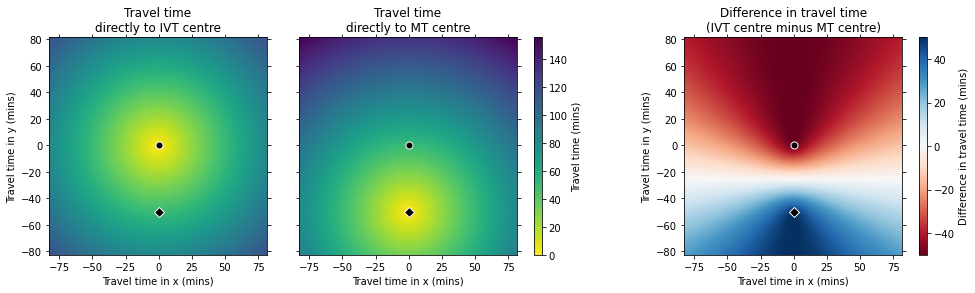

In [13]:
titles = [
    'Travel time'+'\n'+'directly to IVT centre', 
    'Travel time'+'\n'+'directly to MT centre', 
    'Difference in travel time'+'\n'+'(IVT centre minus MT centre)'
    ]

cbar_labels = [
    'Travel time (mins)', 
    'Difference in travel time (mins)'
    ]

plot_two_grids_and_diff(
    grid_time_travel_directly_to_ivt, 
    grid_time_travel_directly_to_mt, 
    grid_time_travel_directly_diff,
    titles=titles, cbar_labels=cbar_labels, 
    extent=extent, cmaps=['viridis_r', 'RdBu'],
    ivt_coords=ivt_coords, mt_coords=mt_coords
    )

On the difference grid, positive values are nearer the IVT/MT centre and negative nearer the IVT-only centre. There is a horizontal line halfway between the two treatment centres that marks where the travel times to the two treatment centres are equal. 

__Presumably the curves in the difference grid match the ones drawn in the Holodinsky et al. 2017 paper.__

### Circle plot

To help define colour limits (`vmin` and `vmax`), gather the coordinates within the largest flattened radiating circle:

In [14]:
from outcome_utilities.geography_plot import find_mask_within_flattened_circle

In [15]:
grid_mask = find_mask_within_flattened_circle(
    grid_time_travel_directly_diff, 
    grid_time_travel_directly_to_ivt, 
    time_travel_max)

coords_valid = np.where(grid_mask<1)

In [16]:
vmin_time = np.nanmin(-grid_time_travel_directly_diff[coords_valid])
vmax_time = np.nanmax(-grid_time_travel_directly_diff[coords_valid])

Update plotting style:

In [17]:
time_step_circle = 5
circ_linewidth = 0.5

In [18]:
from outcome_utilities.geography_plot import circle_plot

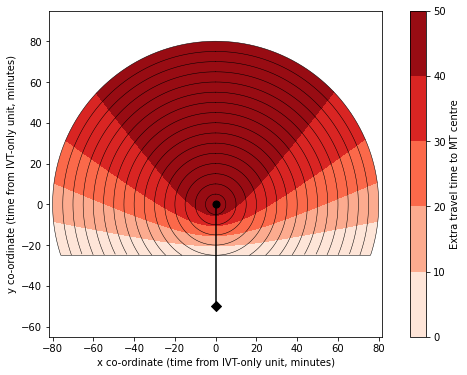

In [19]:
circle_plot(
    -grid_time_travel_directly_diff, fixed_times['travel_ivt_to_mt'], 
    time_travel_max, time_step_circle, vmin_time, vmax_time, imshow=0, 
    cbar_label='Extra travel time to MT centre', extent=extent,
    ivt_coords=ivt_coords, mt_coords=mt_coords, cmap='Reds',
    n_contour_steps=5
    )

---

# Define total time grids (including fixed times for delays)

In [20]:
pd.DataFrame(fixed_times.values(), index=fixed_times.keys(), 
             columns=['Fixed time (minutes)'])

,Fixed time (minutes)
onset_to_ambulance_arrival,60
ivt_arrival_to_treatment,30
transfer_additional_delay,60
travel_ivt_to_mt,50
mt_arrival_to_treatment,90


Time to treatment at the IVT centre:

In [21]:
grid_time_ivt_at_ivtcentre = (
    fixed_times['onset_to_ambulance_arrival'] + 
    grid_time_travel_directly_to_ivt + 
    fixed_times['ivt_arrival_to_treatment']
    )

Time to treatment at the IVT/MT centre _following_ treatment at the IVT centre:

In [22]:
grid_time_ivt_at_ivt_then_mt_at_mtcentre = (
    fixed_times['onset_to_ambulance_arrival'] + 
    grid_time_travel_directly_to_ivt + 
    fixed_times['ivt_arrival_to_treatment'] + 
    fixed_times['transfer_additional_delay'] + 
    fixed_times['travel_ivt_to_mt'] + 
    fixed_times['mt_arrival_to_treatment']
    )

Time to treatment at the MT centre (_skipping_ transport to the IVT centre):

In [23]:
grid_time_ivt_at_mtcentre = (
    fixed_times['onset_to_ambulance_arrival'] + 
    grid_time_travel_directly_to_mt + 
    fixed_times['ivt_arrival_to_treatment']
    )

In [24]:
grid_time_ivt_then_mt_at_mtcentre = (
    fixed_times['onset_to_ambulance_arrival'] + 
    grid_time_travel_directly_to_mt + 
    fixed_times['ivt_arrival_to_treatment'] + 
    fixed_times['mt_arrival_to_treatment']
    )

__check the assumption of time between IVT and MT at the same centre above__

---

## Outcome model

Imports for the clinical outcome model:

In [25]:
from outcome_utilities.clinical_outcome import Clinical_outcome

mrs_dists = pd.read_csv(
    './outcome_utilities/mrs_dist_probs_cumsum.csv', index_col='Stroke type')

# Set up outcome model
outcome_model = Clinical_outcome(mrs_dists)

/home/anna/stroke_outcome/outcome_utilities/clinical_outcome.py:106: RuntimeWarning: divide by zero encountered in true_divide
  o = p / (1 - p)


In [26]:
pd.DataFrame(patient_props.values(), index=patient_props.keys(), 
             columns=['Proportion of patient population'])

,Proportion of patient population
lvo,0.35000
nlvo,0.65000
lvo_mt_also_receiving_ivt,0.85000
lvo_treated_ivt_only,0.00000
lvo_treated_ivt_mt,0.28600
nlvo_treated_ivt_only,0.15500
treated_population,0.20085


Method to find the added utility (c.f. the matrix notebook):

In [27]:
def find_grid_outcomes(outcome_model, grid_time_ivt, grid_time_mt, 
                       patient_props):
    """
    For all pairs of treatment times, calculate the changes in utility
    and mRS for the patient population. 
    
    Inputs:
    
    Returns:
    
    """
    grid_shape = grid_time_ivt.shape
    utility_grid = np.empty(grid_shape)
    mRS_grid = np.empty(grid_shape)

    for row in range(grid_shape[0]):
        for col in range(int(grid_shape[1]*0.5)+1):
            # ^ weird range is for symmetry later when filling grids.
            # Expect col_opp, the opposite column as reflected in the 
            # x=0 axis, to contain the same values as col:
            col_opp = grid_shape[1]-1-col
            
            time_to_ivt = grid_time_ivt[row, col]
            time_to_mt = grid_time_mt[row, col]
            outcomes = outcome_model.calculate_outcomes(
                time_to_ivt, time_to_mt, patients=1000)

            # Find the change in utility:
            added_utility = find_weighted_change(
                outcomes['lvo_ivt_added_utility'],
                outcomes['lvo_mt_added_utility'],
                outcomes['nlvo_ivt_added_utility'],
                patient_props
                )
            # Add this value to the grid:
            utility_grid[row,col] = added_utility
            utility_grid[row,col_opp] = added_utility

            # Find the change in mRS:
            reduced_mRS = find_weighted_change(
                outcomes['lvo_ivt_mean_shift'], 
                outcomes['lvo_mt_mean_shift'],
                outcomes['nlvo_ivt_mean_shift'], 
                patient_props
                )
            # Add this value to the grid:
            mRS_grid[row,col] = reduced_mRS
            mRS_grid[row,col_opp] = reduced_mRS
            
    # Adjust outcome for just treated population
    utility_grid = utility_grid / patient_props['treated_population']
    mRS_grid = mRS_grid / patient_props['treated_population']
    return utility_grid, mRS_grid

In [28]:
def find_weighted_change(change_lvo_ivt, change_lvo_mt, change_nlvo_ivt, 
                         patient_props):
    """
    Take the total changes for each category and calculate their
    weighted sum, where weights are from the proportions of the 
    patient population.
    
    (originally from matrix notebook)
    
    Inputs:
    
    Returns:
    
    """
    # If LVO-IVT is greater change than LVO-MT then adjust MT for 
    # proportion of patients receiving IVT:
    if change_lvo_ivt > change_lvo_mt:
        diff = change_lvo_ivt - change_lvo_mt
        change_lvo_mt += diff * patient_props['lvo_mt_also_receiving_ivt']

    # Calculate changes multiplied by proportions (cp):
    cp_lvo_mt = (
        change_lvo_mt * 
        patient_props['lvo'] * 
        patient_props['lvo_treated_ivt_mt']
        )
    cp_lvo_ivt = (
        change_lvo_ivt * 
        patient_props['lvo'] * 
        patient_props['lvo_treated_ivt_only']
        )
    cp_nlvo_ivt = (
        change_nlvo_ivt * 
        patient_props['nlvo'] * 
        patient_props['nlvo_treated_ivt_only']
        )
        
    total_change = cp_lvo_mt + cp_lvo_ivt + cp_nlvo_ivt
    return total_change

## Grids of changed outcomes

Case 1: IVT at the IVT centre, then MT at the IVT/MT centre

In [29]:
grid_utility_case1, grid_mRS_case1 = find_grid_outcomes(
    outcome_model,
    grid_time_ivt_at_ivtcentre, 
    grid_time_ivt_at_ivt_then_mt_at_mtcentre, 
    patient_props
    )

/home/anna/stroke_outcome/outcome_utilities/clinical_outcome.py:276: RuntimeWarning: invalid value encountered in true_divide
  treated_probs = treated_odds / (1 + treated_odds)
/home/anna/stroke_outcome/outcome_utilities/clinical_outcome.py:316: RuntimeWarning: invalid value encountered in true_divide
  treated_probs = treated_odds / (1 + treated_odds)
/home/anna/stroke_outcome/outcome_utilities/clinical_outcome.py:356: RuntimeWarning: invalid value encountered in true_divide
  treated_probs = treated_odds / (1 + treated_odds)


Case 2: IVT at the IVT/MT centre, then MT at the IVT/MT centre

In [30]:
grid_utility_case2, grid_mRS_case2 = find_grid_outcomes(
    outcome_model,
    grid_time_ivt_at_mtcentre, 
    grid_time_ivt_then_mt_at_mtcentre, 
    patient_props
    )

Difference between them:

In [31]:
grid_utility_diff = grid_utility_case2 - grid_utility_case1
grid_mRS_diff     = grid_mRS_case2     - grid_mRS_case1

---

## Plot the added utility grids

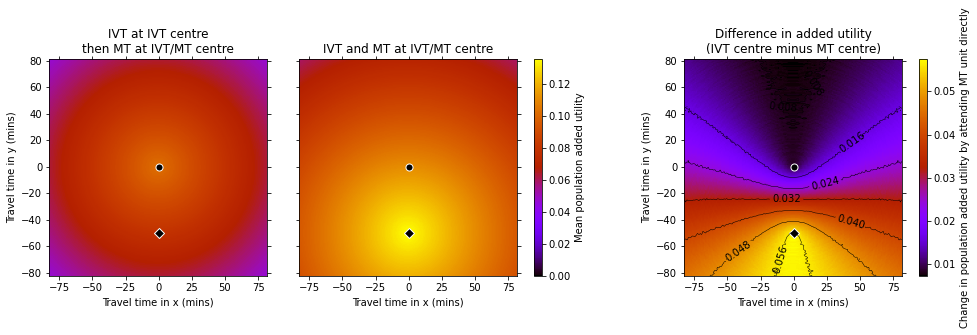

In [32]:
titles = [
    'IVT at IVT centre'+'\n'+'then MT at IVT/MT centre',
    'IVT and MT at IVT/MT centre',
    'Difference in added utility'+'\n'+'(IVT centre minus MT centre)'
    ]

cbar_labels = [
    'Mean population added utility', 
    'Change in population added utility by attending MT unit directly'
    ]

vmin = 0.0 
vmax = np.max([grid_utility_case1, grid_utility_case2])

plot_two_grids_and_diff(
    grid_utility_case1, 
    grid_utility_case2, 
    grid_utility_diff,
    vlims = [[vmin,vmax],[]],
    titles=titles, cbar_labels=cbar_labels, 
    extent=extent, cmaps=['gnuplot','gnuplot'],
    ivt_coords=ivt_coords, mt_coords=mt_coords, plot_contours=1
    )

Getting another horizontal line halfway between the two centres.

Select colour limits for the circle plot:

In [33]:
def round_to_next(vmin, vmax, r=0.005):
    """Round vmin and vmax to nicer values"""
    vmax_r = np.sign(vmax)*np.ceil(np.abs(vmax)/r)*r
    vmin_r = np.floor(vmin/r)*r
    return vmin_r, vmax_r

In [34]:
# Find the actual minumum and maximum values in the grid:
vmin_total = np.nanmin(grid_utility_diff[coords_valid])
vmax_total = np.nanmax(grid_utility_diff[coords_valid])

vmin_util, vmax_util = round_to_next(vmin_total, vmax_total, 0.005)

print('Max. value in grid:', vmax_total)
print('Chosen vmax:       ', vmax_util)
print('Min. value in grid:', vmin_total)
print('Chosen vmin:       ', vmin_util)

Max. value in grid: 0.03308757281553397
Chosen vmax:        0.035
Min. value in grid: 0.00713702265372175
Chosen vmin:        0.005


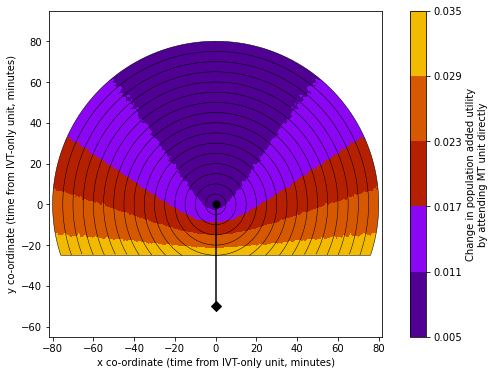

In [35]:
circle_plot(
    grid_utility_diff, fixed_times['travel_ivt_to_mt'], 
    time_travel_max, time_step_circle, vmin_util, vmax_util, imshow=0, 
    cmap='gnuplot', extent=extent,
    cbar_label=('Change in population added utility\n'+
                'by attending MT unit directly'),
    n_contour_steps = 5, 
    # cbar_format_str='{:3.3f}',
    ivt_coords=ivt_coords, mt_coords=mt_coords
    )

---

## Plot the reduced mRS grids

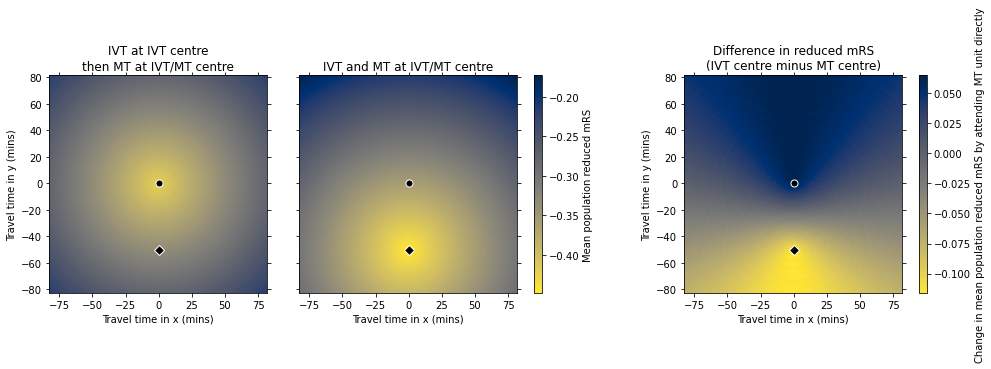

In [36]:
titles = [
    'IVT at IVT centre'+'\n'+'then MT at IVT/MT centre',
    'IVT and MT at IVT/MT centre',
    'Difference in reduced mRS'+'\n'+'(IVT centre minus MT centre)'
    ]

cbar_labels = [
    'Mean population reduced mRS',
    'Change in mean population reduced mRS by attending MT unit directly',
    ]

plot_two_grids_and_diff(
    grid_mRS_case1, 
    grid_mRS_case2, 
    grid_mRS_diff,
    vlims = [[],[]],
    titles=titles, cbar_labels=cbar_labels, 
    extent=extent, cmaps=['cividis_r','cividis_r'],
    ivt_coords=ivt_coords, mt_coords=mt_coords
    )

Getting another horizontal line halfway between the two centres.

Select colour limits for the circle plot:

In [37]:
# Find the actual maximum value in the grid:
vmin_total = np.nanmin(grid_mRS_diff[coords_valid])
vmax_total = np.nanmax(grid_mRS_diff[coords_valid])

# Round this up to the nearest nicer thing of our choice:
vmin_mRS, vmax_mRS = round_to_next(vmin_total, vmax_total, 0.005)

print('Max. value in grid:', vmax_total)
print('Chosen vmax:       ', vmax_mRS)
print('Min. value in grid:', vmin_total)
print('Chosen vmin:       ', vmin_mRS)

Max. value in grid: 0.06483462783171529
Chosen vmax:        0.065
Min. value in grid: -0.026090291262135967
Chosen vmin:        -0.03


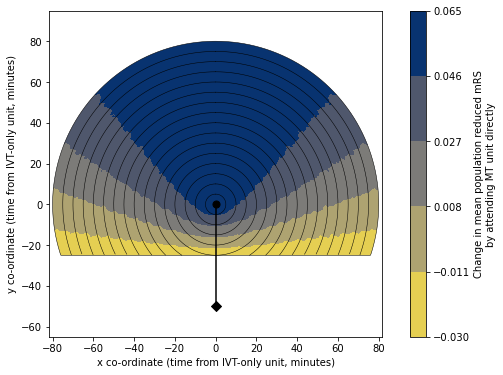

In [38]:
circle_plot(
    grid_mRS_diff, fixed_times['travel_ivt_to_mt'], 
    time_travel_max, time_step_circle, vmin_mRS, vmax_mRS, imshow=0, 
    cmap='cividis_r', extent=extent,
    cbar_label=('Change in mean population reduced mRS\n'+
               'by attending MT unit directly'),
    # cbar_format_str='{:3.2f}', 
    n_contour_steps=5,
    ivt_coords=ivt_coords, mt_coords=mt_coords
    )

---

# Combined circle plot

Condense this notebook into one cell and make a separate figure for each combination of fixed times:

+ Travel time from IVT to MT centre: 30, 60, or 90 mins
+ Onset to ambulance arrival time: 30, 60, or 90 mins

In [90]:
time_list_travel_ivt_to_mt = [30, 60, 90]
time_list_onset_to_ambulance_arrival = [60]#[30, 60, 90]

In [76]:
def make_levels_with_zeroish(level_step, vmax, zeroish=5e-3, vmin=None):
    if vmin==None:
        vmin = -vmax
        
    levels = np.arange(vmin, vmax+level_step*0.9, level_step)

    levels = levels[np.where(np.abs(levels)>zeroish)]
    levels_zero_buffer = np.array([-zeroish, zeroish])
    levels = np.unique(np.sort(np.concatenate((levels, levels_zero_buffer))))
    return levels

In [72]:
cmap_time = 'Reds'
# try:
#     import cmasher as cmr 
#     cmap_util = 'cmr.viola'
#     cmap_mRS = 'cmr.viola_r'
# except:
cmap_util = 'bwr_r'
cmap_mRS = 'bwr'

[[1.         0.59607843 0.59607843 1.        ]
 [1.         0.60392157 0.60392157 1.        ]
 [1.         0.61176471 0.61176471 1.        ]
 ...
 [0.00784314 0.00784314 1.         1.        ]
 [0.         0.         1.         1.        ]
 [0.         0.         1.         1.        ]]
[[0.8        0.8        1.         1.        ]
 [0.80784314 0.80784314 1.         1.        ]
 [0.80784314 0.80784314 1.         1.        ]
 ...
 [1.         0.00784314 0.00784314 1.        ]
 [1.         0.         0.         1.        ]
 [1.         0.         0.         1.        ]]


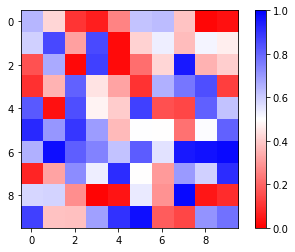

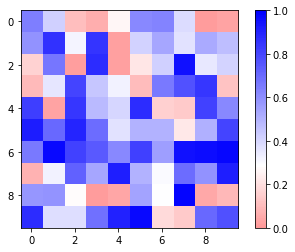

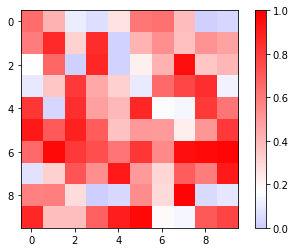

0.30000000000000004 0.4


In [92]:
from matplotlib import colors

# Share levels and colours between all figures. 
vmin_time = 0 
vmax_time = np.max(time_list_travel_ivt_to_mt)

# Seems to be some theoretical minimum mRS and maximum utility change:
vmin_util = -0.014
vmax_util = 0.035 
vmin_mRS = -0.030
vmax_mRS = 0.150

lin_min_util = 0.5 - 0.5*abs(vmin_util/vmax_util)
colors_util = plt.get_cmap('bwr_r')(np.linspace(lin_min_util, 1.0, 256))
print(colors_util)
cmap_util = colors.LinearSegmentedColormap.from_list('colormap', colors_util)


lin_min_mRS = 0.5 - 0.5*abs(vmin_mRS/vmax_mRS)
colors_mRS = plt.get_cmap('bwr')(np.linspace(lin_min_mRS, 1.0, 256))
print(colors_mRS)
cmap_mRS = colors.LinearSegmentedColormap.from_list('colormap', colors_mRS)


colors_time = plt.get_cmap('bwr')(np.linspace(0.5, 1.0, 256))
cmap_time = colors.LinearSegmentedColormap.from_list('colormap', colors_time)


arr = np.random.rand(10,10)

plt.imshow(arr, vmin=0.0, vmax=1.0, cmap='bwr_r')
plt.colorbar()
plt.show()

plt.imshow(arr, vmin=0.0, vmax=1.0, cmap=cmap_util)
plt.colorbar()
plt.show()


plt.imshow(arr, vmin=0.0, vmax=1.0, cmap=cmap_mRS)
plt.colorbar()
plt.show()

print(lin_min_util, lin_min_mRS)

In [93]:
# Define contour levels:
# vmax_abs_util = np.max(np.abs([vmin_util, vmax_util]))
level_step_util = 0.007
levels_util = make_levels_with_zeroish(level_step_util, vmax_util, zeroish=5e-4, vmin=vmin_util)

# vmax_abs_mRS = np.max(np.abs([vmin_mRS, vmax_mRS]))
# vmax_abs_mRS = np.max(np.abs([vmin_mRS, vmax_mRS]))
level_step_mRS = 0.03
levels_mRS = make_levels_with_zeroish(level_step_mRS, vmax_mRS, zeroish=2e-3, vmin=vmin_mRS)

print(levels_util)
print(levels_mRS)

[-0.014  -0.007  -0.0005  0.0005  0.007   0.014   0.021   0.028   0.035 ]
[-0.03  -0.002  0.002  0.03   0.06   0.09   0.12   0.15 ]


/home/anna/stroke_outcome/outcome_utilities/clinical_outcome.py:276: RuntimeWarning: invalid value encountered in true_divide
  treated_probs = treated_odds / (1 + treated_odds)
/home/anna/stroke_outcome/outcome_utilities/clinical_outcome.py:316: RuntimeWarning: invalid value encountered in true_divide
  treated_probs = treated_odds / (1 + treated_odds)
/home/anna/stroke_outcome/outcome_utilities/clinical_outcome.py:356: RuntimeWarning: invalid value encountered in true_divide
  treated_probs = treated_odds / (1 + treated_odds)


--------------------------------------------------
Time of travel from IVT to MT: 30
Time from onset to ambulance arrival: 60


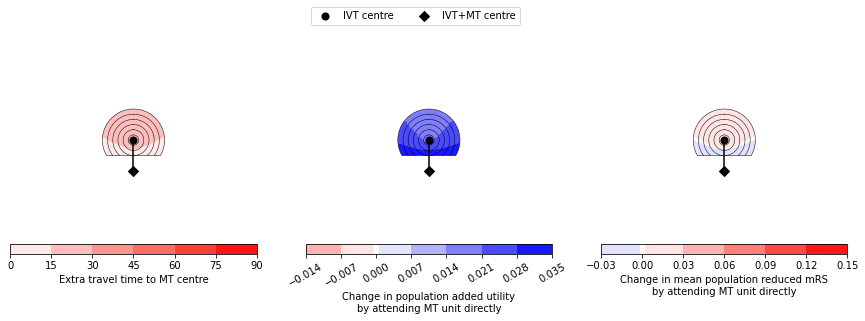

/home/anna/stroke_outcome/outcome_utilities/clinical_outcome.py:276: RuntimeWarning: invalid value encountered in true_divide
  treated_probs = treated_odds / (1 + treated_odds)
/home/anna/stroke_outcome/outcome_utilities/clinical_outcome.py:316: RuntimeWarning: invalid value encountered in true_divide
  treated_probs = treated_odds / (1 + treated_odds)
/home/anna/stroke_outcome/outcome_utilities/clinical_outcome.py:356: RuntimeWarning: invalid value encountered in true_divide
  treated_probs = treated_odds / (1 + treated_odds)


--------------------------------------------------
Time of travel from IVT to MT: 60
Time from onset to ambulance arrival: 60


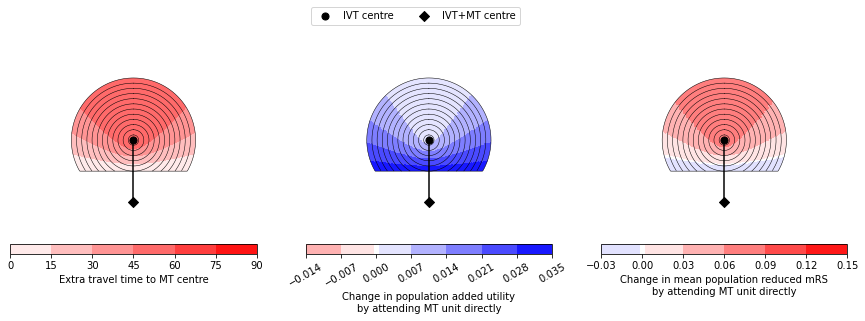

/home/anna/stroke_outcome/outcome_utilities/clinical_outcome.py:276: RuntimeWarning: invalid value encountered in true_divide
  treated_probs = treated_odds / (1 + treated_odds)
/home/anna/stroke_outcome/outcome_utilities/clinical_outcome.py:316: RuntimeWarning: invalid value encountered in true_divide
  treated_probs = treated_odds / (1 + treated_odds)
/home/anna/stroke_outcome/outcome_utilities/clinical_outcome.py:356: RuntimeWarning: invalid value encountered in true_divide
  treated_probs = treated_odds / (1 + treated_odds)


--------------------------------------------------
Time of travel from IVT to MT: 90
Time from onset to ambulance arrival: 60


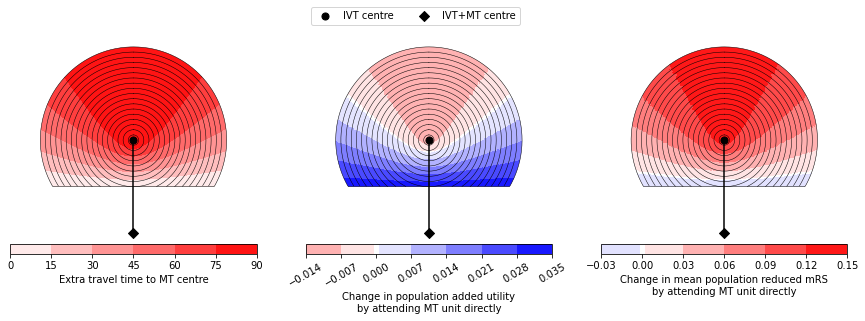

In [95]:
for time_travel_ivt_to_mt in time_list_travel_ivt_to_mt:
        
    # Recalculate some values: 
    ivt_coords = [0, 0]
    mt_coords  = [0, -time_travel_ivt_to_mt]

    # Only calculate travel times up to this x or y displacement:
    time_travel_max = time_travel_ivt_to_mt#100

    # Change how granular the grid is. 
    grid_step = 1 # minutes

    # Make the grid a bit larger than the max travel time: 
    grid_xy_max = time_travel_max + grid_step*2

    grid_time_travel_directly_to_ivt = make_time_grid(
        grid_xy_max, grid_step, x_offset=ivt_coords[0], y_offset=ivt_coords[1])

    grid_time_travel_directly_to_mt = make_time_grid(
        grid_xy_max, grid_step, x_offset=mt_coords[0], y_offset=mt_coords[1])

    grid_time_travel_directly_diff = (
        grid_time_travel_directly_to_ivt - grid_time_travel_directly_to_mt)

    extent = [-grid_xy_max - grid_step*0.5, 
              +grid_xy_max - grid_step*0.5, 
              -grid_xy_max - grid_step*0.5, 
              +grid_xy_max - grid_step*0.5] 
    
    grid_mask = find_mask_within_flattened_circle(
        grid_time_travel_directly_diff, 
        grid_time_travel_directly_to_ivt, 
        time_travel_max)
    coords_valid = np.where(grid_mask<1)
        
    for time_onset_to_ambulance_arrival in (
        time_list_onset_to_ambulance_arrival):

        # Define new time grids: 
        grid_time_ivt_at_ivtcentre = (
            time_onset_to_ambulance_arrival + 
            grid_time_travel_directly_to_ivt + 
            fixed_times['ivt_arrival_to_treatment']
            )

        grid_time_ivt_at_ivt_then_mt_at_mtcentre = (
            time_onset_to_ambulance_arrival + 
            grid_time_travel_directly_to_ivt + 
            fixed_times['ivt_arrival_to_treatment'] + 
            fixed_times['transfer_additional_delay'] + 
            fixed_times['travel_ivt_to_mt'] + 
            fixed_times['mt_arrival_to_treatment']
            )

        grid_time_ivt_at_mtcentre = (
            time_onset_to_ambulance_arrival + 
            grid_time_travel_directly_to_mt + 
            fixed_times['ivt_arrival_to_treatment']
            )

        grid_time_ivt_then_mt_at_mtcentre = (
            time_onset_to_ambulance_arrival + 
            grid_time_travel_directly_to_mt + 
            fixed_times['ivt_arrival_to_treatment'] + 
            fixed_times['mt_arrival_to_treatment']
            )
        
        # Grids of changed outcomes
        
        # Case 1: IVT at the IVT centre, then MT at the IVT/MT centre
        grid_utility_case1, grid_mRS_case1 = find_grid_outcomes(
            outcome_model,
            grid_time_ivt_at_ivtcentre, 
            grid_time_ivt_at_ivt_then_mt_at_mtcentre, 
            patient_props
            )

        # Case 2: IVT at the IVT/MT centre, then MT at IVT/MT centre
        grid_utility_case2, grid_mRS_case2 = find_grid_outcomes(
            outcome_model,
            grid_time_ivt_at_mtcentre, 
            grid_time_ivt_then_mt_at_mtcentre, 
            patient_props
            )

        # Difference between them:
        grid_utility_diff = grid_utility_case2 - grid_utility_case1
        grid_mRS_diff     = grid_mRS_case2     - grid_mRS_case1

        print('-'*50)
        print(f'Time of travel from IVT to MT: {time_travel_ivt_to_mt:2d}')
        print(f'Time from onset to ambulance arrival: {time_onset_to_ambulance_arrival:2d}')
        

        # Plotting!  
        fig, axs = plt.subplots(2, 3, figsize=(15,4), 
        gridspec_kw={'wspace':0.2, 'hspace':0.0, 'height_ratios':[20,1]})
        ax_time = axs[0,0]
        ax_time_cbar = axs[1,0]
        ax_util = axs[0,1]
        ax_util_cbar = axs[1,1]
        ax_mRS = axs[0,2]
        ax_mRS_cbar = axs[1,2]


        circle_plot(
            -grid_time_travel_directly_diff, time_travel_ivt_to_mt, 
            time_travel_max, time_step_circle, vmin_time, vmax_time, imshow=0, 
            cbar_label='Extra travel time to MT centre', extent=extent,
            ivt_coords=ivt_coords, mt_coords=mt_coords, cmap=cmap_time,
            n_contour_steps=6,
            ax=ax_time, cax=ax_time_cbar, cbar_orientation='horizontal')

        # Draw legend now:
        fig.legend(loc='upper center', bbox_to_anchor=[0.5,1.0], ncol=2)

        circle_plot(
            grid_utility_diff, time_travel_ivt_to_mt, 
            time_travel_max, time_step_circle, 
            vmin_util, vmax_util, imshow=0, 
            cmap=cmap_util, extent=extent,
            cbar_label=('Change in population added utility\n'+
                        'by attending MT unit directly'),
            levels=levels_util,
            # n_contour_steps = 10, 
            # cbar_format_str='{:3.3f}',
            ivt_coords=ivt_coords, mt_coords=mt_coords,
            ax=ax_util, cax=ax_util_cbar, cbar_orientation='horizontal',
            cbar_ticks=np.arange(vmin_util, vmax_util+level_step_util, level_step_util))

        for tick in ax_util_cbar.get_xticklabels():
            tick.set_rotation(30)

        circle_plot(
            grid_mRS_diff, time_travel_ivt_to_mt, 
            time_travel_max, time_step_circle, 
            vmin_mRS, vmax_mRS, imshow=0, 
            cmap=cmap_mRS, extent=extent,
            cbar_label='Change in mean population reduced mRS\n'+
                        'by attending MT unit directly',
            # cbar_format_str='{:3.2f}', 
            levels=levels_mRS, # 
            # n_contour_steps=17,
            ivt_coords=ivt_coords, mt_coords=mt_coords,
            ax=ax_mRS, cax=ax_mRS_cbar, cbar_orientation='horizontal',
            cbar_ticks=
            np.arange(vmin_mRS, vmax_mRS+level_step_mRS, level_step_mRS))
        

        for ax in [ax_time, ax_util, ax_mRS]:
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.set_xticks([])
            ax.set_yticks([])
            for spine in ['top', 'bottom', 'left', 'right']:
                ax.spines[spine].set_color('None')
            # ax.set_ylim(-fixed_times['travel_ivt_to_mt']*1.1, time_travel_max*1.02)
            # ax.set_ylim(-time_travel_ivt_to_mt-15, time_travel_ivt_to_mt+15)
            ax.set_ylim(-90-10, 90+10)

        filename = ('circle_plots'+
            f'_t-IVT-to-MT={time_travel_ivt_to_mt:2d}'+
            f'_t-onset-to-ambo={time_onset_to_ambulance_arrival:2d}')
        plt.savefig('./images/'+filename+'.jpg', dpi=300, bbox_inches='tight')
        plt.show()